In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/har25indoor/HARDATA_SHREYA/desktop.ini
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_161.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_206.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_153.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_102.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_002.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_012.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_134.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_052.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_148.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_136.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_165.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_041.jpg
/kaggle/input/har25indoor/HARDATA_SHREYA/watching tv/watching_TV_205.jp

In [2]:
!pip install -q transformers datasets

In [3]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/har25indoor/HARDATA_SHREYA")

Resolving data files:   0%|          | 0/5480 [00:00<?, ?it/s]

In [4]:
train_ds = dataset['train']

In [5]:
splits = train_ds.train_test_split(test_size=0.15)
train_ds = splits['train']
val_ds = splits['test']

In [6]:
splits2 = train_ds.train_test_split(test_size=0.15)
train_ds = splits2['train']
test_ds = splits2['test']

In [7]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Washing Dishes',
 1: 'applauding',
 2: 'brushing teeth',
 3: 'cleaning the floor',
 4: 'cooking',
 5: 'cutting veggies',
 6: 'dancing',
 7: 'drinking',
 8: 'eating',
 9: 'fighting',
 10: 'hugging',
 11: 'laughing',
 12: 'phoning',
 13: 'pouring a liquid',
 14: 'reading',
 15: 'sitting',
 16: 'sleeping',
 17: 'smoking',
 18: 'taking photos',
 19: 'texting',
 20: 'using a computer',
 21: 'watching tv',
 22: 'waving hands',
 23: 'writing on a board',
 24: 'writing on a book'}

In [8]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

2024-06-08 04:23:34.073150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 04:23:34.073213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 04:23:34.074726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [10]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [11]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    output_dir='/kaggle/working/my_model',
    run_name = "my_vit",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [15]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [16]:
import wandb

wandb.login()

wandb: Currently logged in as: sagnik-sengupta123 (sagniksengupta14). Use `wandb login --relogin` to force relogin


True

In [17]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [18]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.685032,0.582927
2,No log,2.127341,0.668293
3,2.603200,1.786960,0.728049
4,2.603200,1.569210,0.765854
5,2.603200,1.436740,0.774390
6,1.737500,1.318902,0.804878
7,1.737500,1.251006,0.802439
8,1.395900,1.199154,0.823171
9,1.395900,1.163768,0.828049
10,1.395900,1.151778,0.828049


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=1980, training_loss=1.7545768968986741, metrics={'train_runtime': 1105.7405, 'train_samples_per_second': 35.677, 'train_steps_per_second': 1.791, 'total_flos': 3.0576891777094656e+18, 'train_loss': 1.7545768968986741, 'epoch': 10.0})

In [19]:
outputs = trainer.predict(test_ds)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [20]:
print(outputs.metrics)

{'test_loss': 1.150881052017212, 'test_accuracy': 0.8421807747489239, 'test_runtime': 10.3799, 'test_samples_per_second': 67.149, 'test_steps_per_second': 8.478}


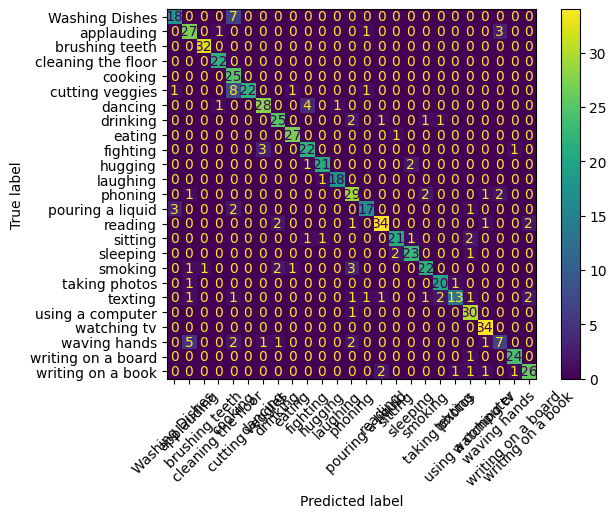

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77        25
           1       0.75      0.84      0.79        32
           2       0.97      1.00      0.98        32
           3       0.92      1.00      0.96        22
           4       0.56      1.00      0.71        25
           5       1.00      0.67      0.80        33
           6       0.88      0.82      0.85        34
           7       0.83      0.83      0.83        30
           8       0.93      0.96      0.95        28
           9       0.79      0.85      0.81        26
          10       0.91      0.88      0.89        24
          11       0.95      0.95      0.95        19
          12       0.74      0.83      0.78        35
          13       0.85      0.74      0.79        23
          14       0.89      0.85      0.87        40
          15       0.88      0.81      0.84        26
          16       0.88      0.88      0.88        26
          17       0.85    

In [31]:
trainer.save_model("/kaggle/working/vision_transformer_model")